In [75]:
import geopandas as gpd
import pandas as pd
import ee
import numpy as np
from scipy.stats import linregress, gaussian_kde
from src.data import mtbs
from src.data import raster
from src.data import pd_utils
from src.data import gedi_pipeline
from src.visualization.gedi_viz import geo_plot
import rasterio as rio
import matplotlib.pyplot as plt
from shapely.geometry import Point
from rasterio.plot import show
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
sns.set_theme()

import importlib
importlib.reload(raster)
importlib.reload(gedi_pipeline)

2023-05-11 14:14:41,967 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.gedi_pipeline' from '/home/jk871/fire-regen/src/data/gedi_pipeline.py'>

In [73]:
gedi_gpd = gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/sierras_matched_lc_all_2x2.csv')
print(f'Total number of GEDI shots available for the region: {gedi_gpd.shape[0]}')

Total number of GEDI shots available for the region: 9884257


In [77]:
gedi_gpd = gedi_pipeline.process_shots(gedi_gpd)

### Filter GEDI data

In [80]:
gedi_burned, gedi_unburned = gedi_pipeline.filter_shots(gedi_gpd)

2023-05-11 14:25:16,278 DEBUG: Excluded shots on the burn boundaries, shots remaining:         9446235 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:36]
2023-05-11 14:25:22,241 DEBUG: Number of GEDI shots that burned at least once:                  1440937 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:41]
2023-05-11 14:27:21,795 DEBUG: Number of GEDI shots that never burned since 1984:         7852535 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:47]


In [81]:
gedi_burned = gedi_pipeline.filter_shots_for_regrowth_analysis(gedi_burned)

2023-05-11 14:27:31,770 DEBUG: Number of shots that happened after fires:                    1248004 [in filter_shots_for_regrowth_analysis at /home/jk871/fire-regen/src/data/gedi_pipeline.py:64]
2023-05-11 14:27:33,544 DEBUG: Number of shots that burned exactly once:                    1085566 [in filter_shots_for_regrowth_analysis at /home/jk871/fire-regen/src/data/gedi_pipeline.py:69]
2023-05-11 14:27:35,299 DEBUG: Number of shots that burned in 2-4 categories:                    917889 [in filter_shots_for_regrowth_analysis at /home/jk871/fire-regen/src/data/gedi_pipeline.py:74]
2023-05-11 14:27:36,019 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 3x3 pixels have the same severity):                    651178 [in filter_shots_for_regrowth_analysis at /home/jk871/fire-regen/src/data/gedi_pipeline.py:78]


### Presence of plant classes in each GEDI category

Land cover is being currently derived from Dynamic World estimate from 2019. Legend:
* 0 - water
* 1 - trees
* 2 - grass
* 3 - flooded_vegetation
* 4 - crops
* 5 - shrub_and_scrub
* 6 - built
* 7 - bare
* 8 - snow and ice

TODO: Actually obtain land cover from the time before fire for burned pixels.

<AxesSubplot: xlabel='land_cover_median', ylabel='Count'>

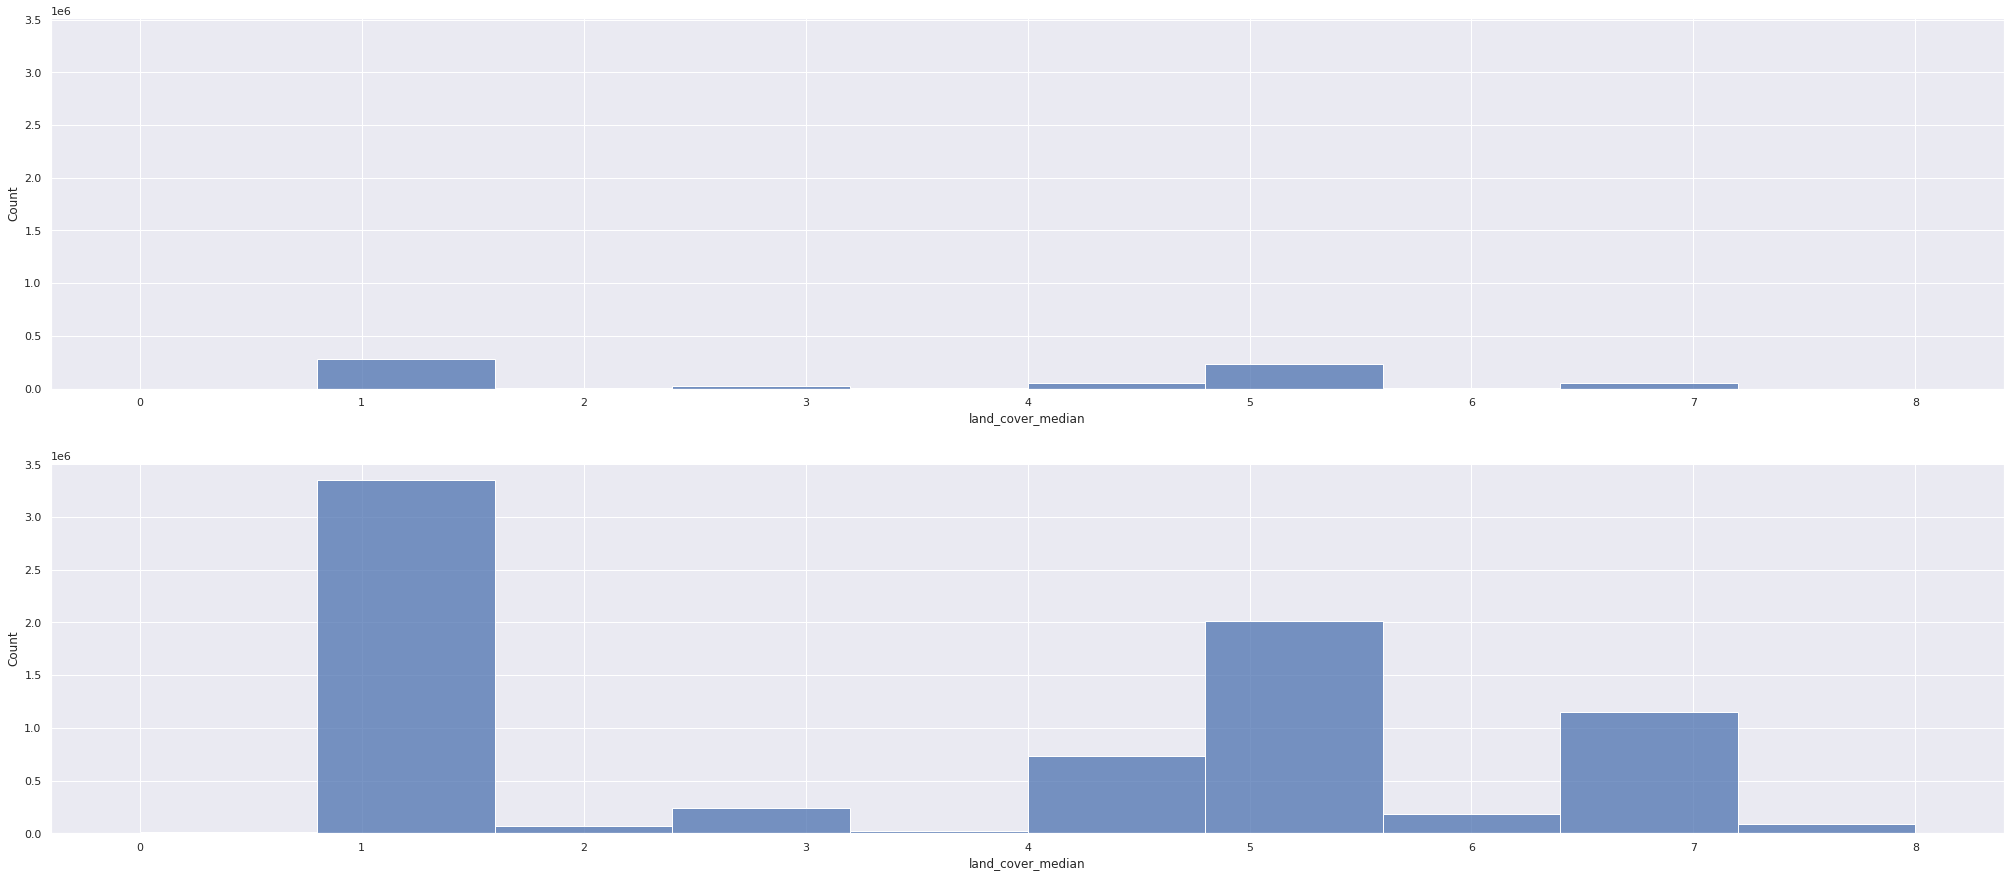

In [82]:
fig, ax = plt.subplots(2, 1, figsize=(35, 15), sharey=True)
sns.histplot(gedi_burned, x='land_cover_median', ax=ax[0], bins=10)
sns.histplot(gedi_unburned, x='land_cover_median', ax=ax[1], bins=10)

### Analyze only trees - land cover == 1

In [83]:
gedi_burned_trees = gedi_pipeline.filter_for_trees(gedi_burned)
gedi_unburned_trees = gedi_pipeline.filter_for_trees(gedi_unburned)
print(f'GEDI shots that burned trees: {gedi_burned_trees.shape[0]}')
print(f'GEDI tree shots that didn\'t burn: {gedi_unburned_trees.shape[0]}')

GEDI shots that burned trees: 260640
GEDI tree shots that didn't burn: 3152125


In [84]:
gedi_trees = pd.concat([gedi_burned_trees, gedi_unburned_trees])

In [85]:
# Get rid of the first two years as the number of samples is skewing the data.
gedi_trees = gedi_trees[(gedi_trees.time_since_burn != 1) & ((gedi_trees.time_since_burn != 2))]

In [86]:
gedi_trees = gedi_pipeline.add_time_since_burn_categories(gedi_trees)

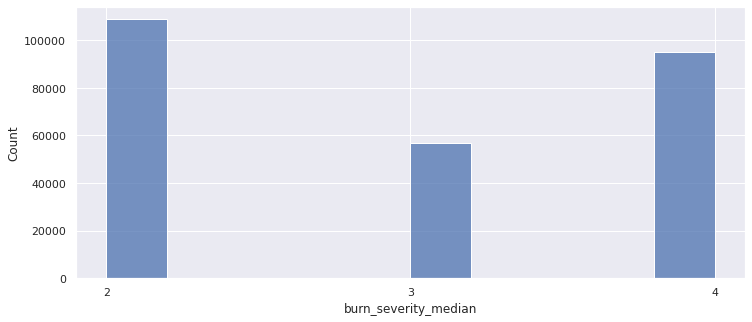

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
g = sns.histplot(gedi_burned_trees, x='burn_severity_median', bins=10)
g.set_xticks(range(2, 5))

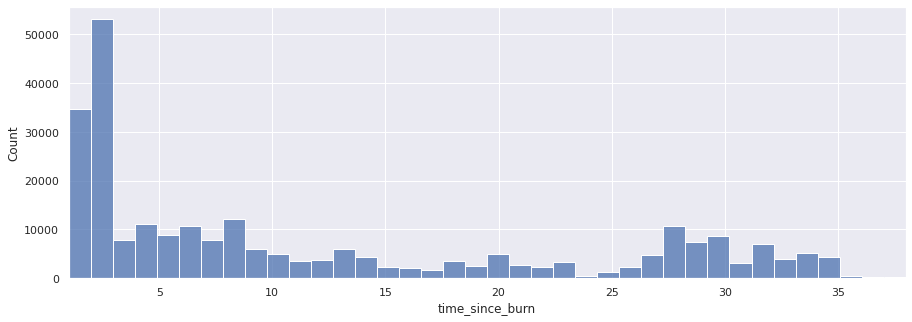

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
g = sns.histplot(gedi_burned_trees, x='time_since_burn', bins=38)
ax.margins(x=0)

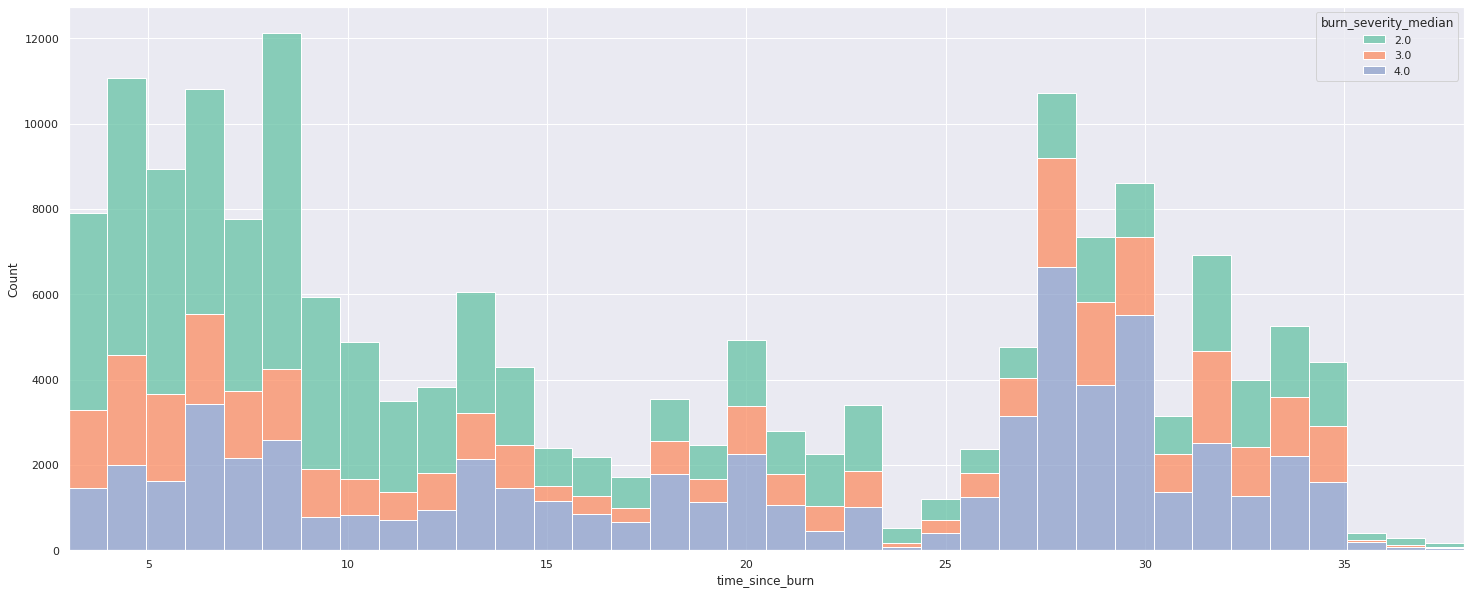

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.histplot(gedi_trees[gedi_trees.time_since_burn != -1], x='time_since_burn', hue='burn_severity_median', palette='Set2', multiple="stack", bins=36)
ax.margins(x=0)

### Boxplot comparisons

(0.0, 1000.0)

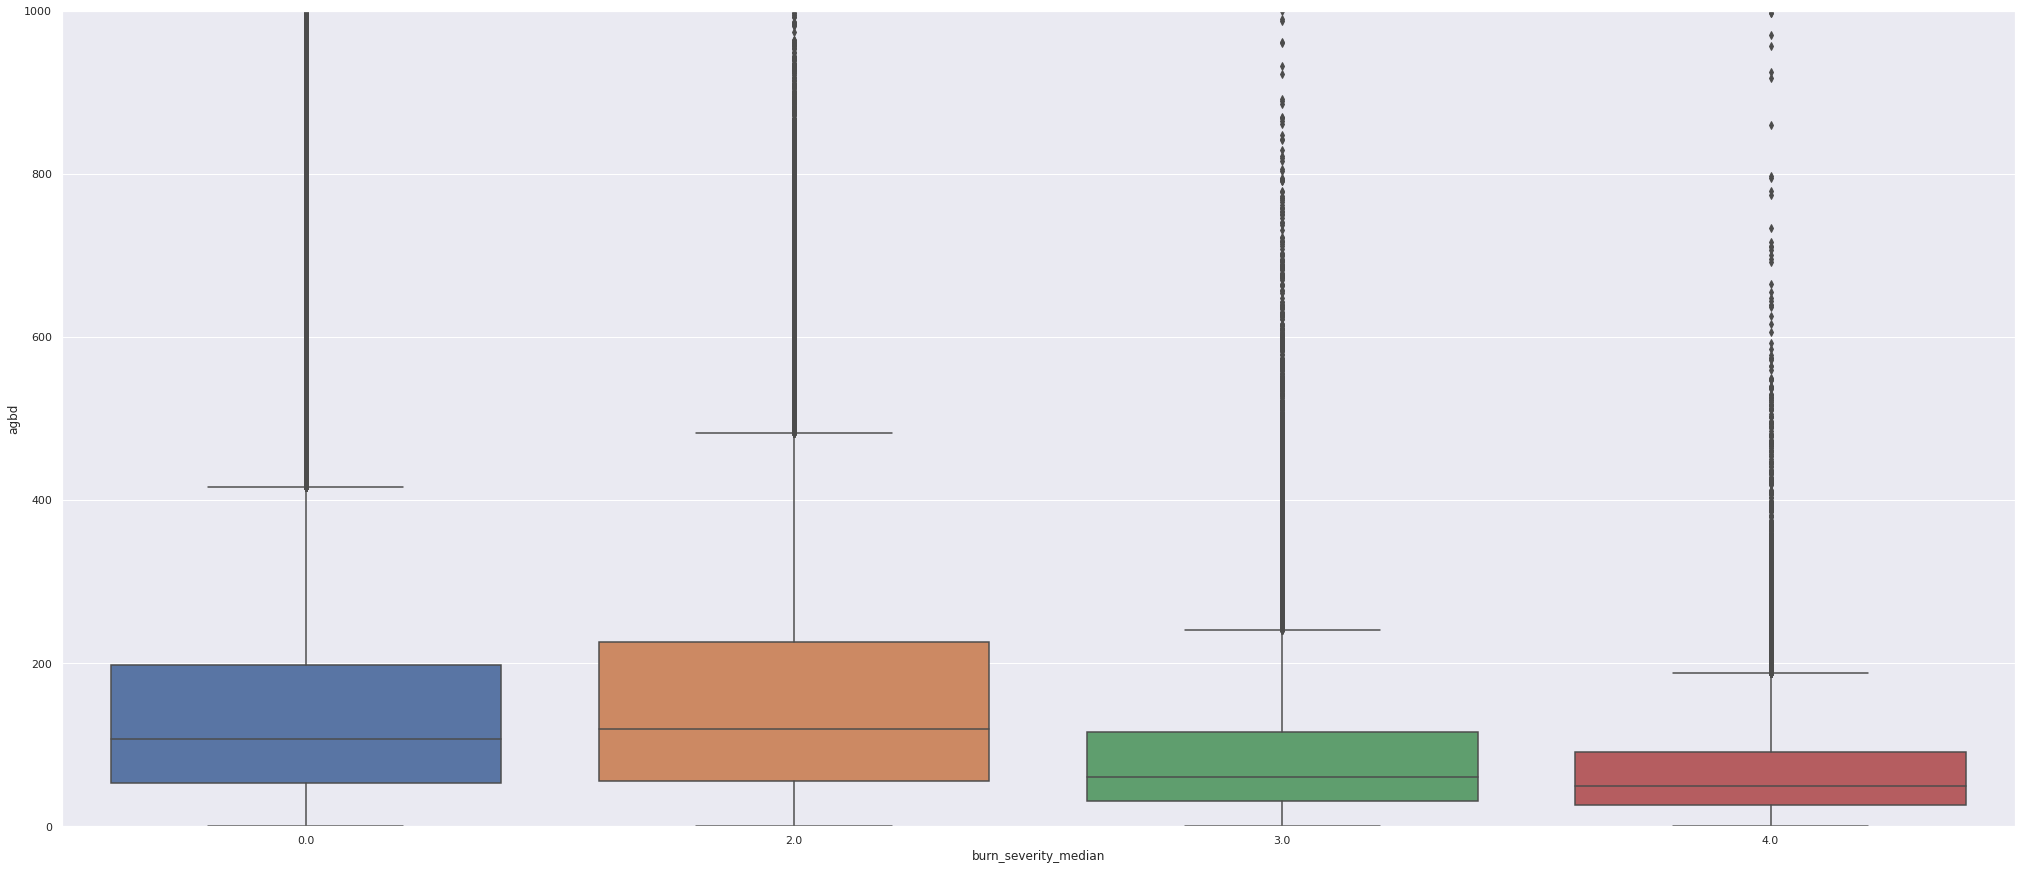

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.boxplot(gedi_trees, x='burn_severity_median', y='agbd')
ax.set_ylim((0, 1000))

(0.0, 1000.0)

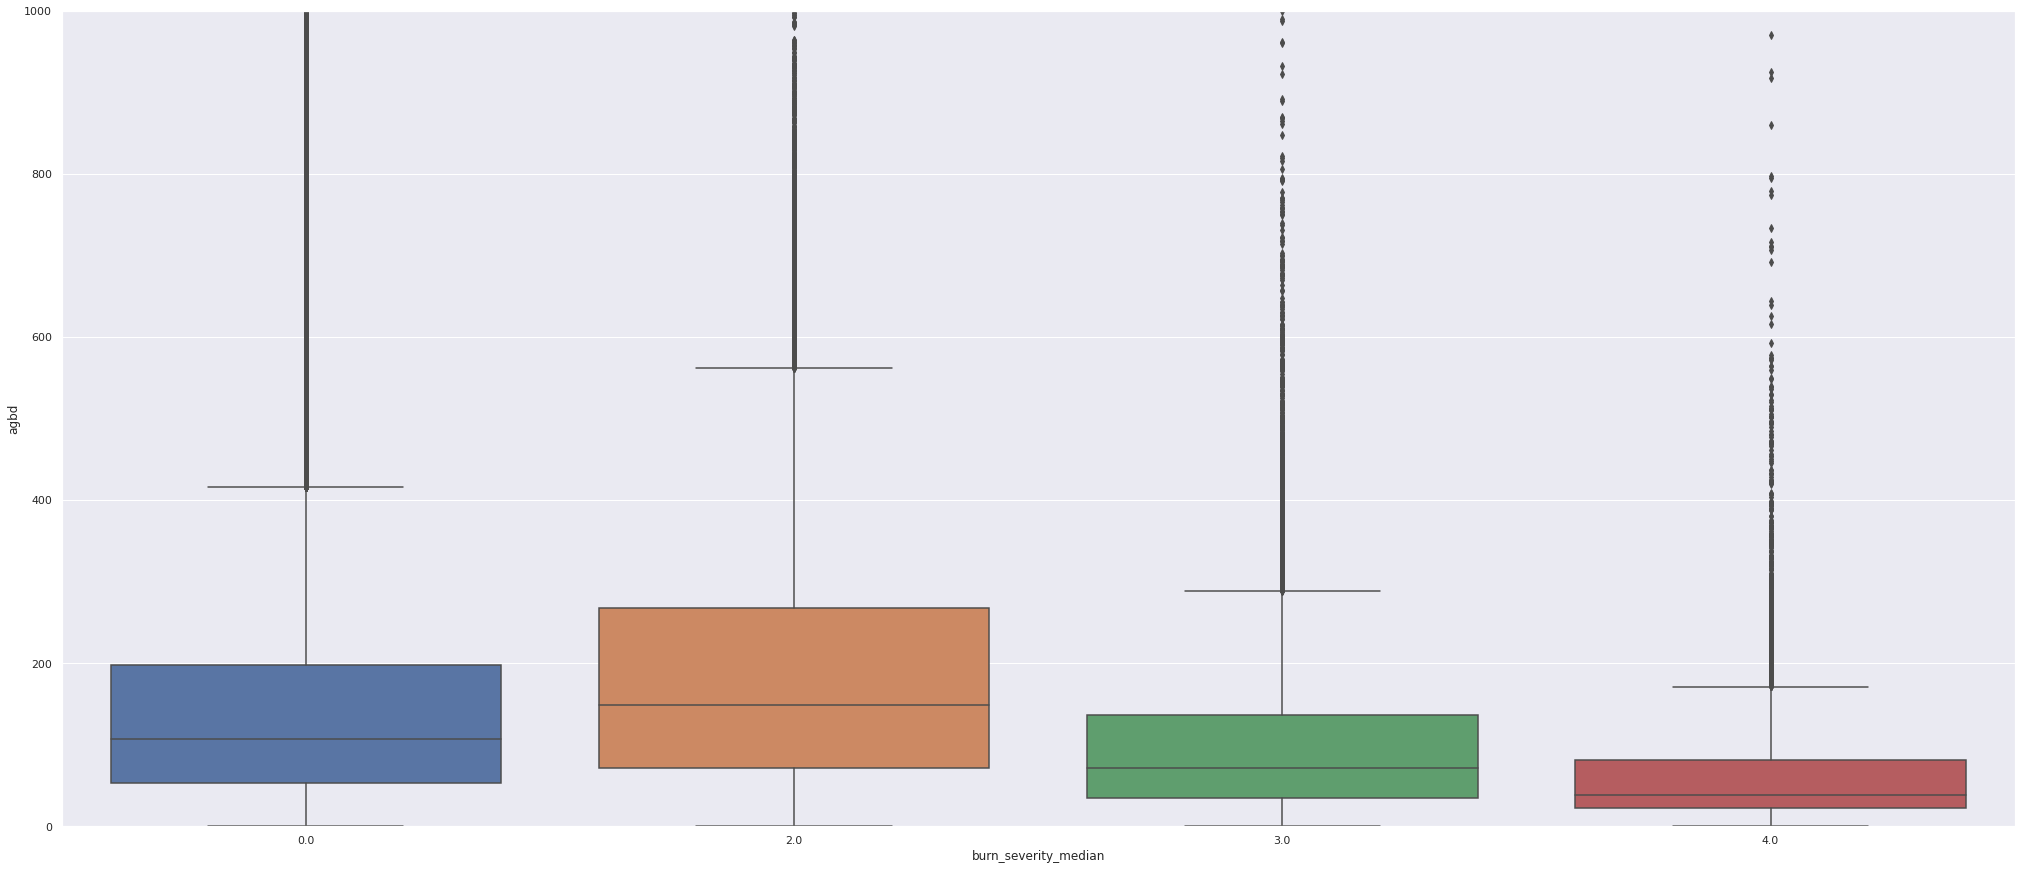

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.boxplot(gedi_trees[gedi_trees.time_since_burn_cat.isin(['unburned', 'burn_10'])], x='burn_severity_median', y='agbd')
ax.set_ylim((0, 1000))

(0.0, 1000.0)

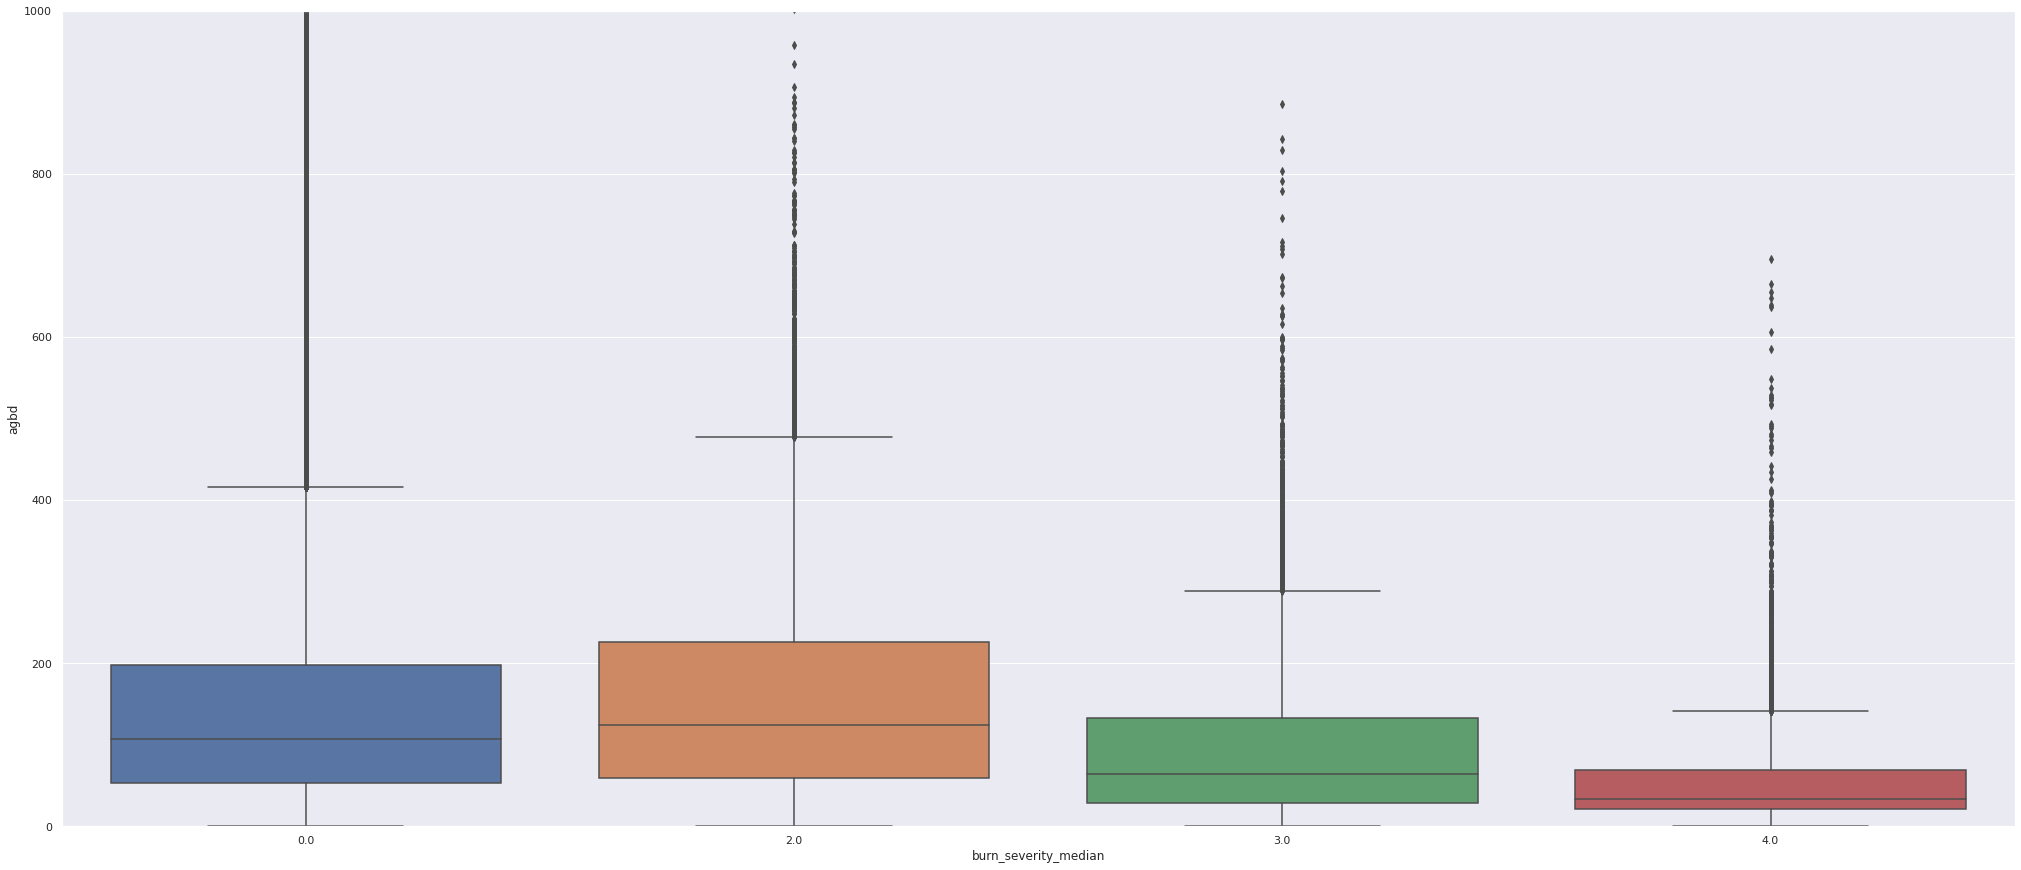

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.boxplot(gedi_trees[gedi_trees.time_since_burn_cat.isin(['unburned', 'burn_20'])], x='burn_severity_median', y='agbd')
ax.set_ylim((0, 1000))

(0.0, 1000.0)

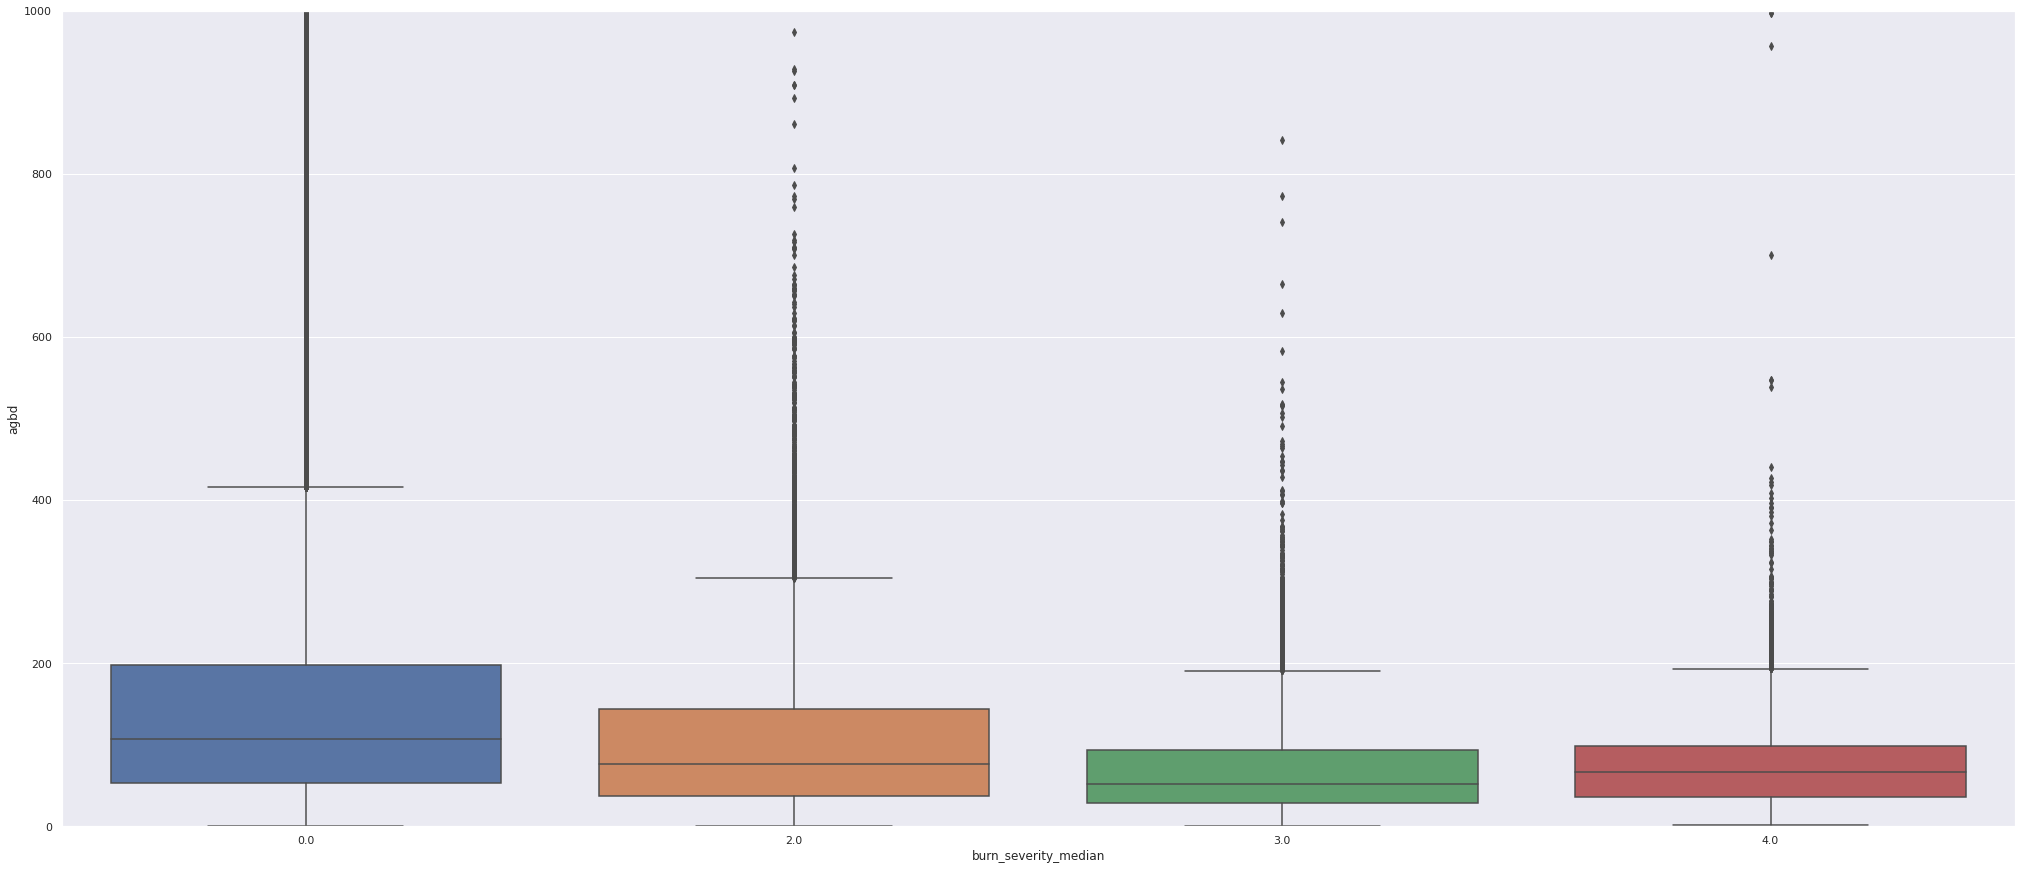

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.boxplot(gedi_trees[gedi_trees.time_since_burn_cat.isin(['unburned', 'burn_30'])], x='burn_severity_median', y='agbd')
ax.set_ylim((0, 1000))

(0.0, 1000.0)

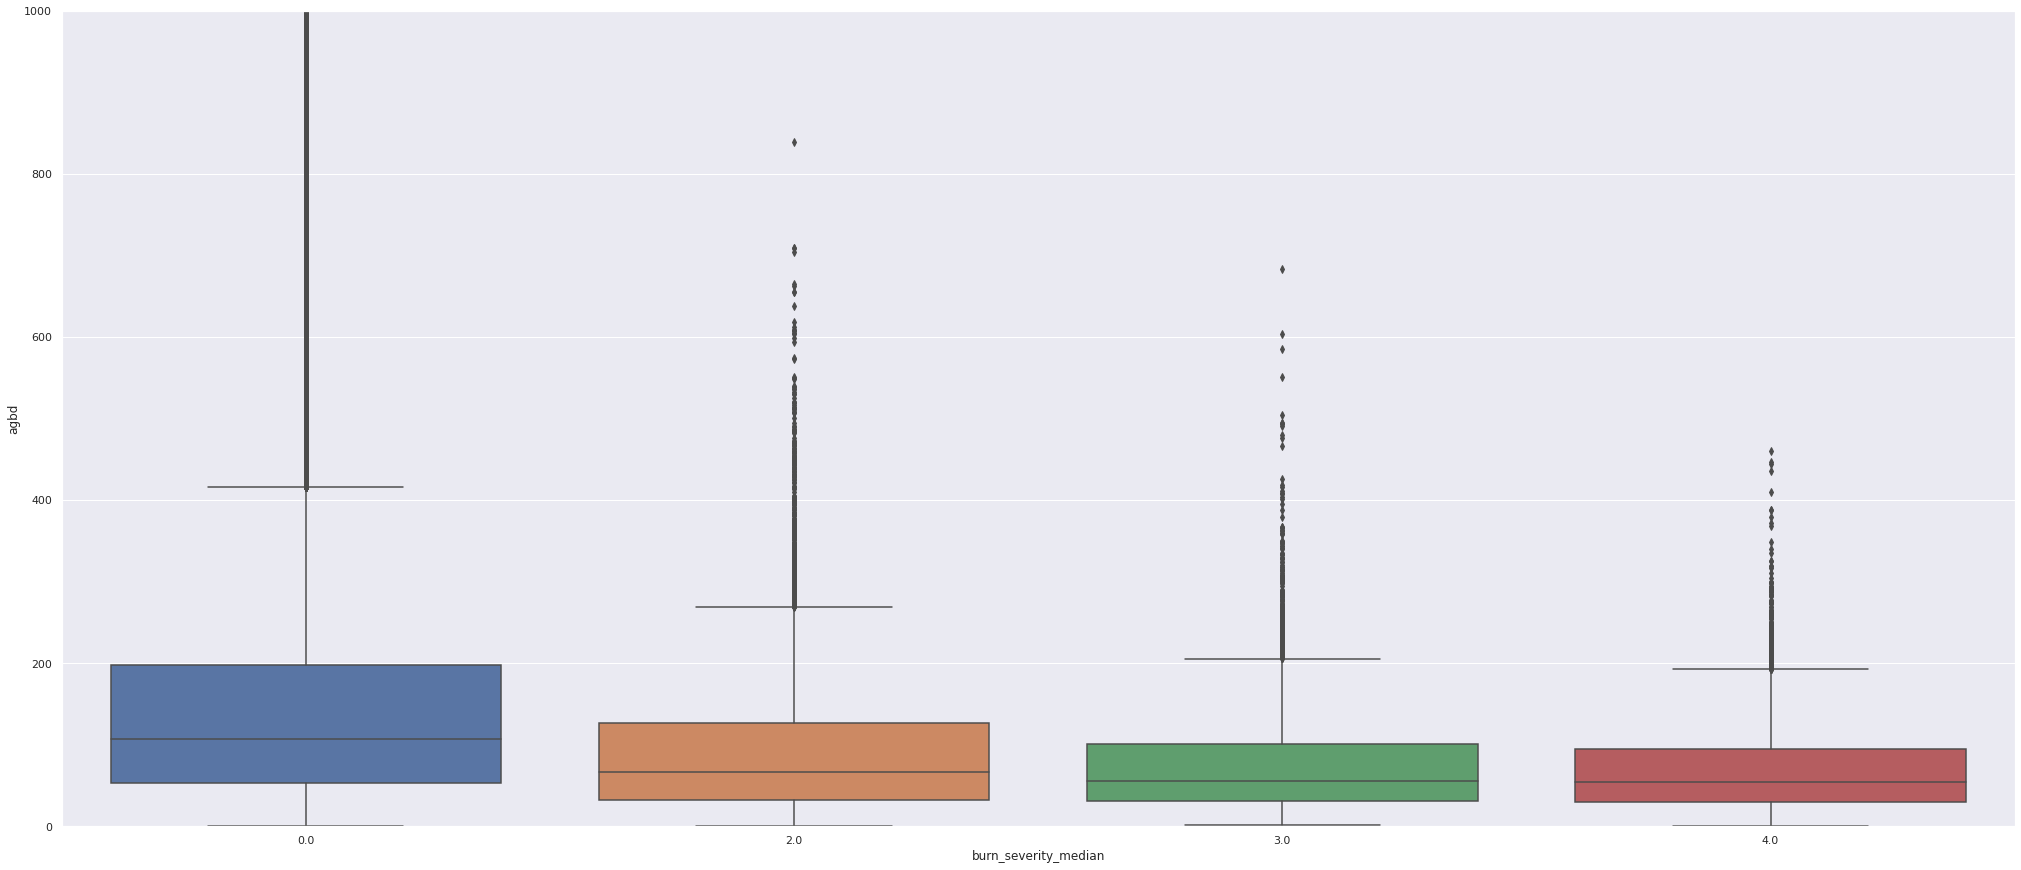

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
sns.boxplot(gedi_trees[gedi_trees.time_since_burn_cat.isin(['unburned', 'burn_40'])], x='burn_severity_median', y='agbd')
ax.set_ylim((0, 1000))

# AGBD timeplots

<AxesSubplot: xlabel='time_since_burn', ylabel='agbd'>

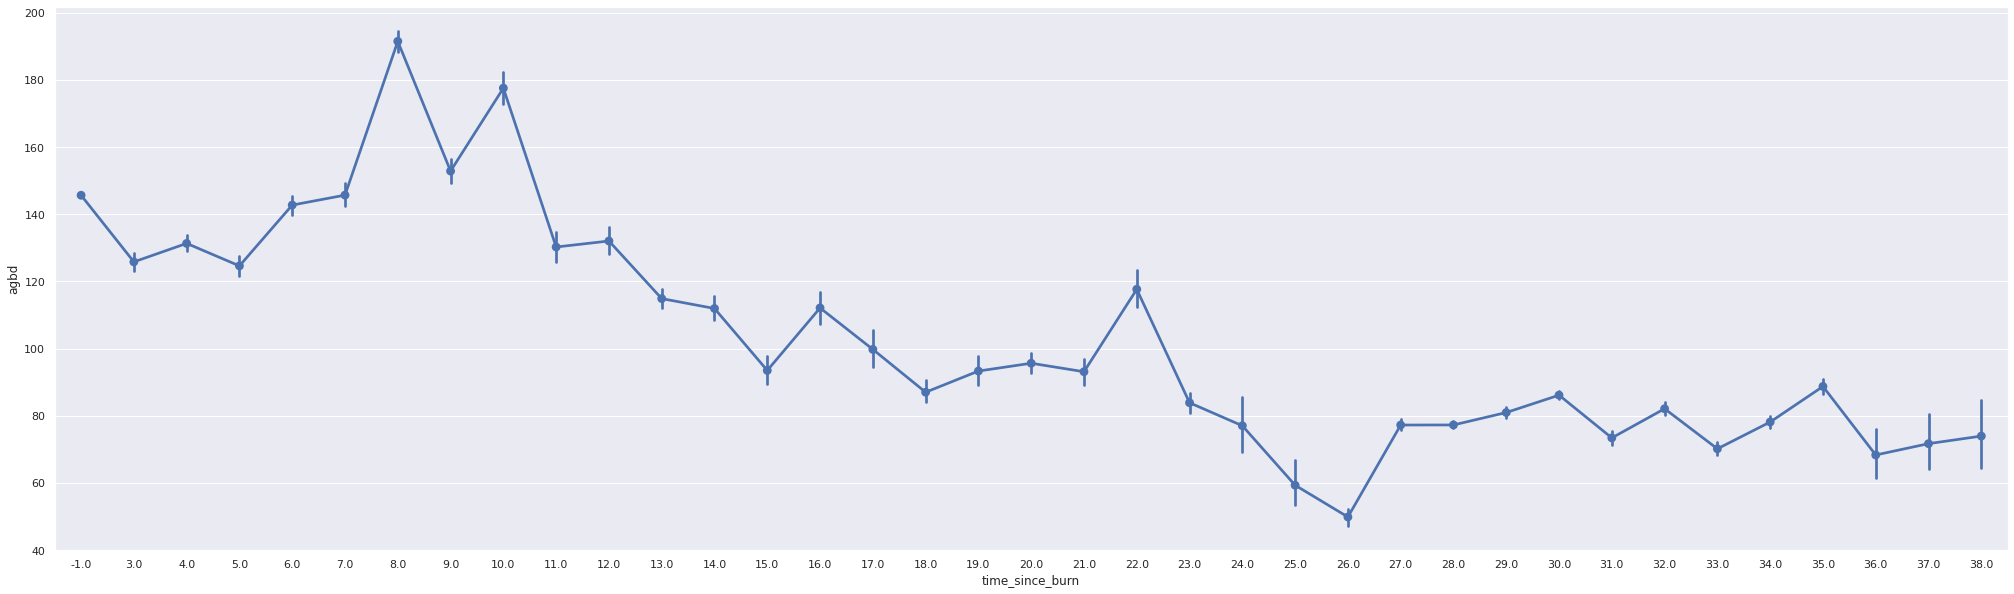

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_trees, x='time_since_burn', y='agbd')

<AxesSubplot: xlabel='time_since_burn', ylabel='agbd'>

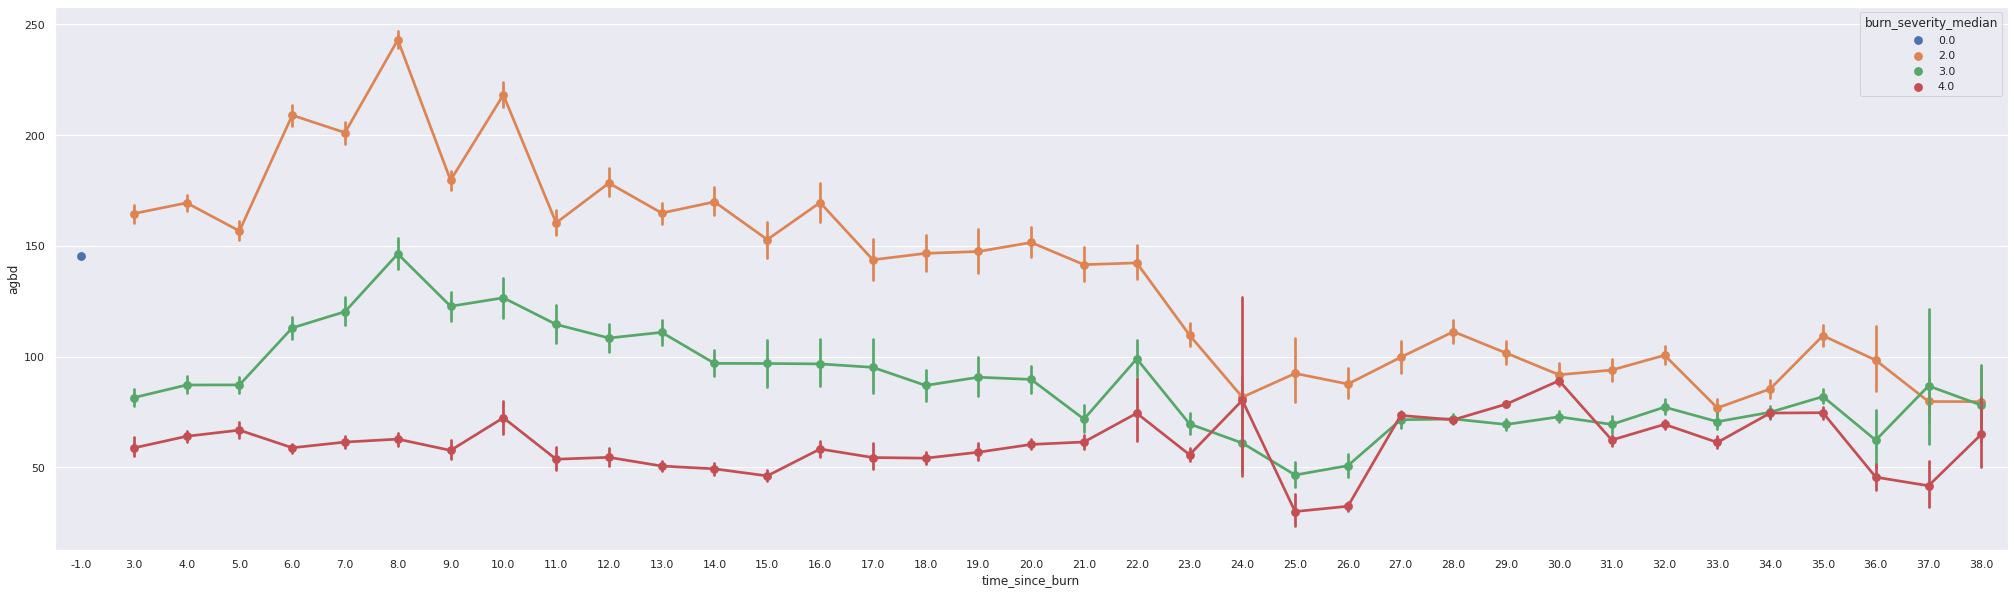

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_trees, x='time_since_burn', y='agbd', hue='burn_severity_median')

Text(0, 0.5, 'GEDI AGBD')

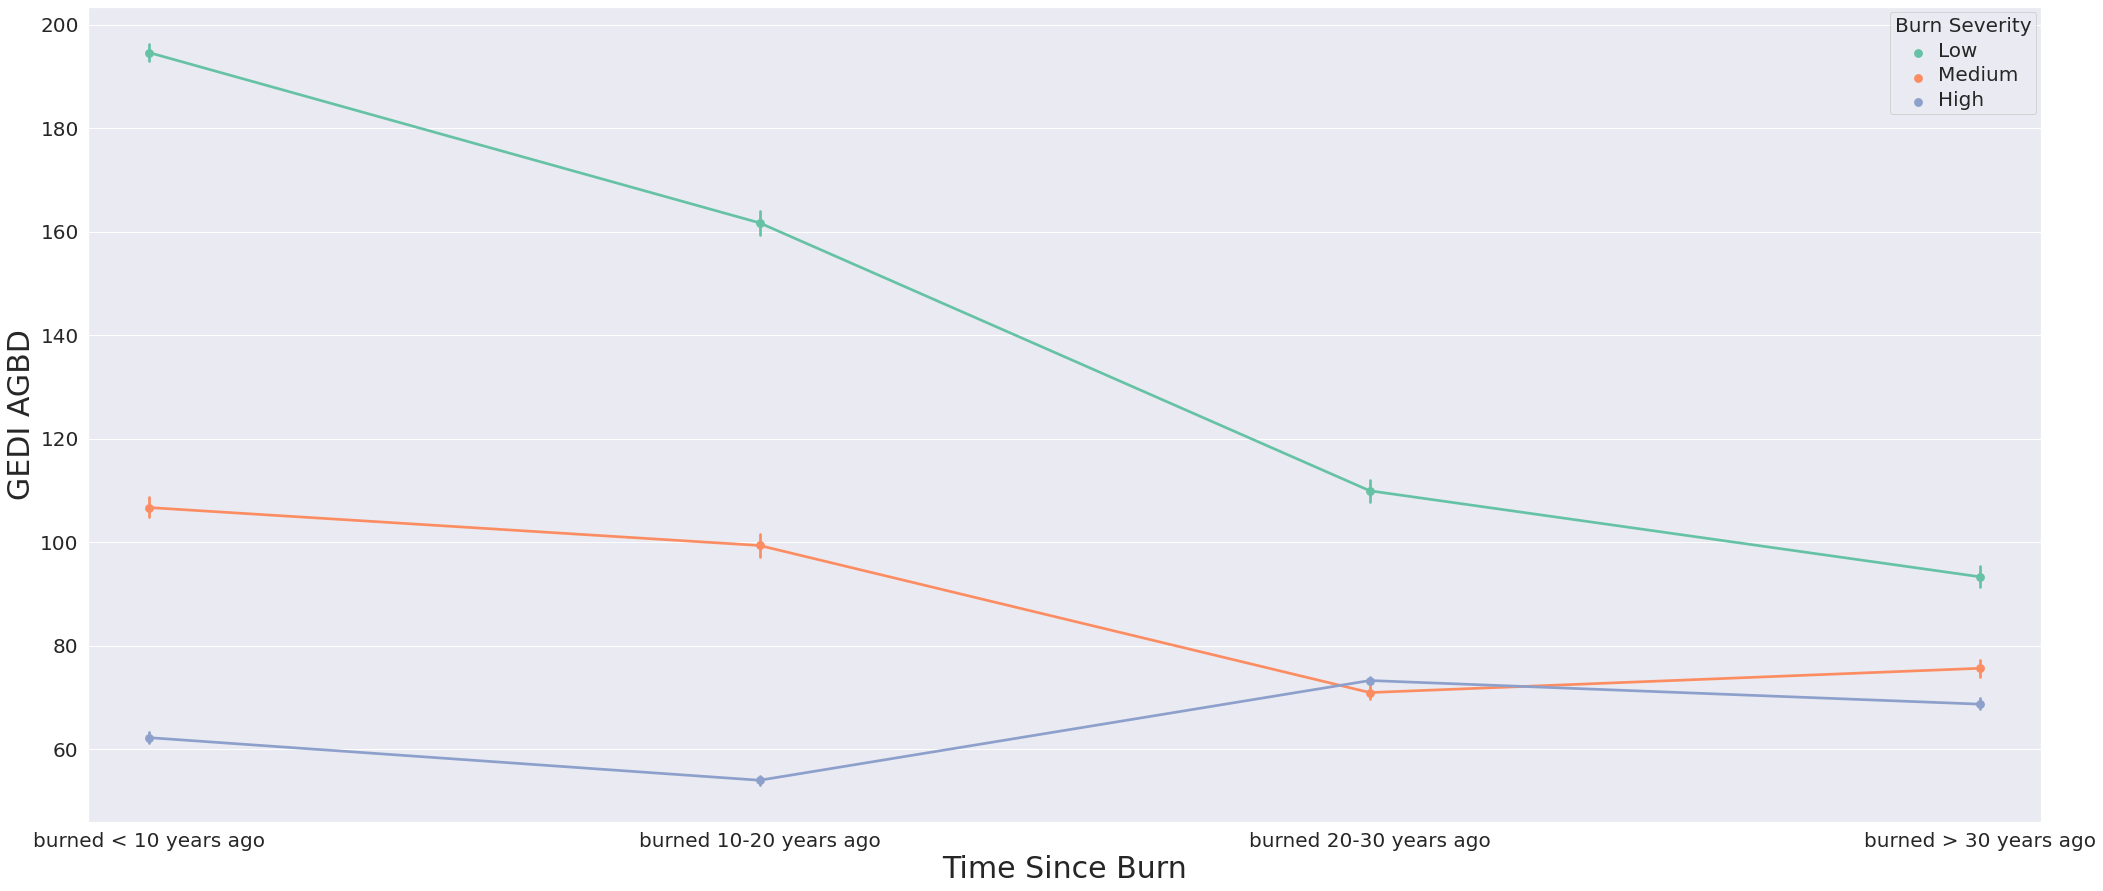

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
g = sns.pointplot(gedi_trees[gedi_trees.time_since_burn != -1], x='time_since_burn_cat', y='agbd', hue='burn_severity_median', palette='Set2')
g.get_legend().set_title('Burn Severity')
new_labels = ['Low', 'Medium', 'High']
for t, l in zip(g.get_legend().texts, new_labels):
    t.set_text(l)

plt.setp(g.get_legend().get_texts(), fontsize='20') 
plt.setp(g.get_legend().get_title(), fontsize='20') 

#plt.legend(title='Burn Severity', loc='upper right', labels=['Low', 'Medium', 'High'])
ax.set_xticks([1, 2, 3, 4])
ax.set_xlim((0.9, 4.1))
ax.set_xticklabels(['burned < 10 years ago', 'burned 10-20 years ago', 'burned 20-30 years ago', 'burned > 30 years ago'])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Time Since Burn', fontsize=30)
ax.set_ylabel('GEDI AGBD', fontsize=30)

Text(0, 0.5, 'GEDI AGBD')

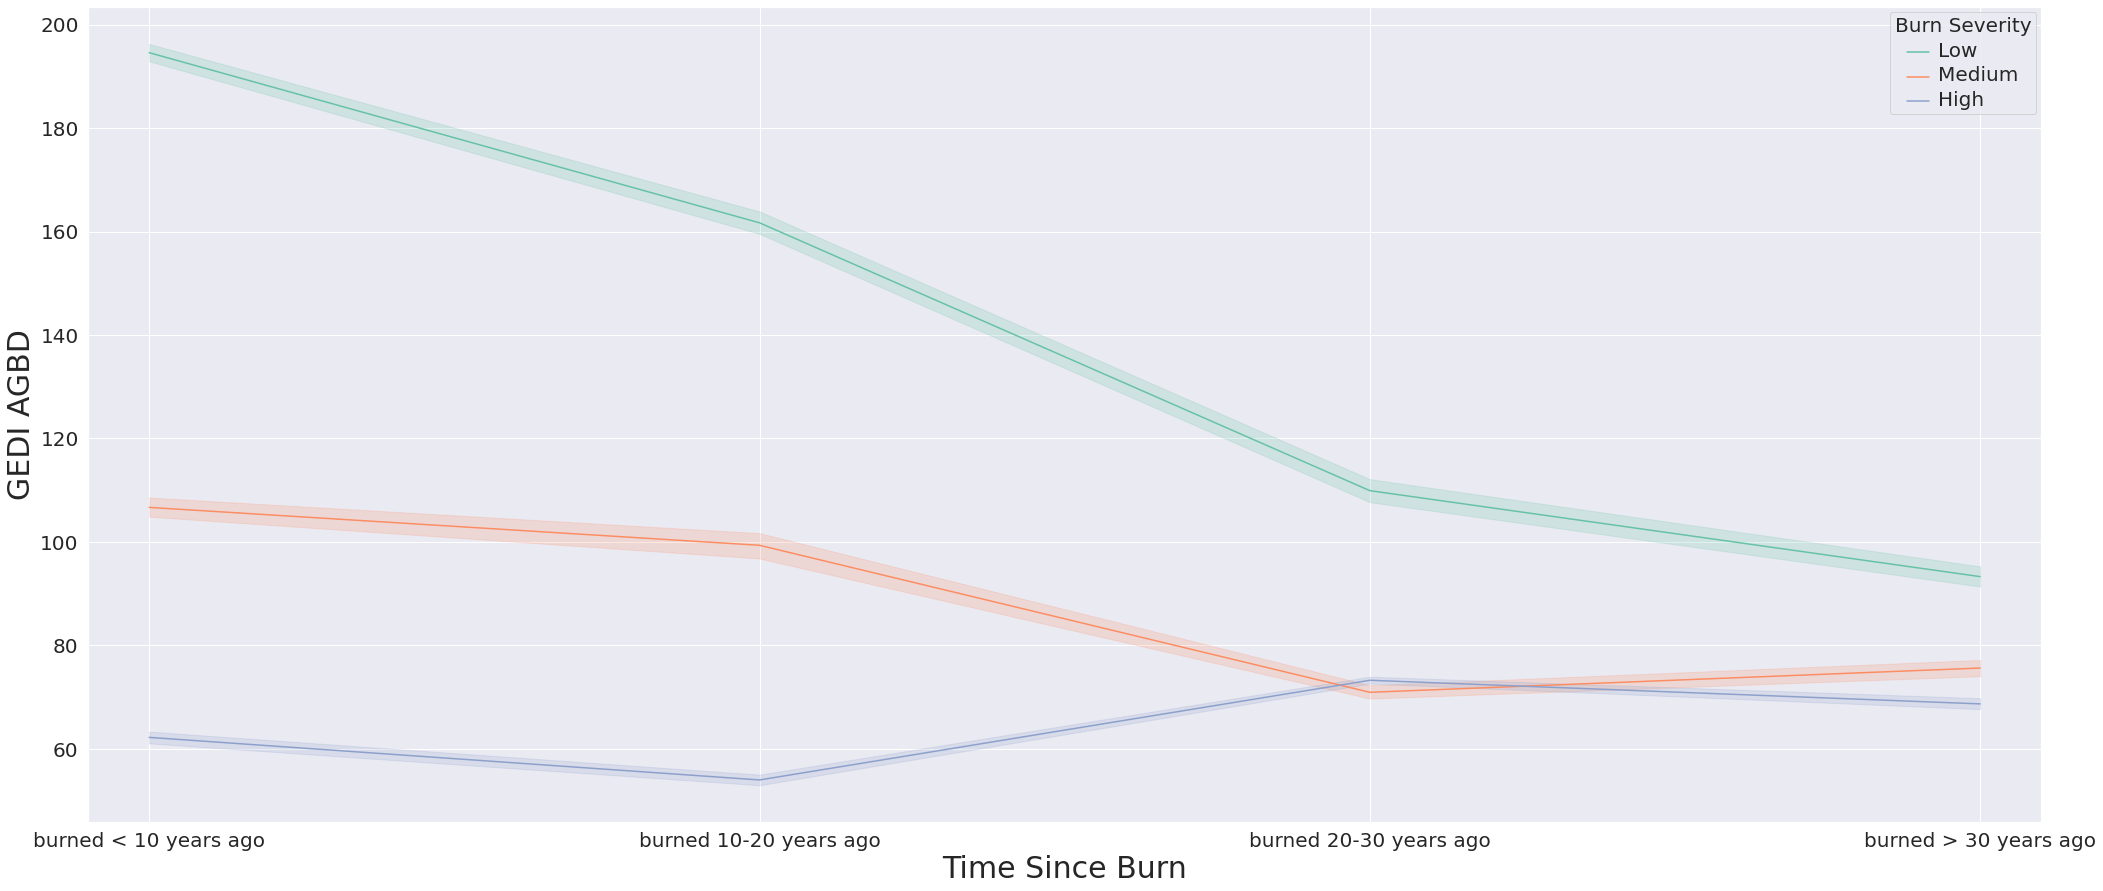

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
g = sns.lineplot(gedi_trees[gedi_trees.time_since_burn != -1], x='time_since_burn_cat', y='agbd', hue='burn_severity_median', palette='Set2')
g.get_legend().set_title('Burn Severity')
new_labels = ['Low', 'Medium', 'High']
for t, l in zip(g.get_legend().texts, new_labels):
    t.set_text(l)

plt.setp(g.get_legend().get_texts(), fontsize='20') 
plt.setp(g.get_legend().get_title(), fontsize='20') 

#plt.legend(title='Burn Severity', loc='upper right', labels=['Low', 'Medium', 'High'])
ax.set_xticks([1, 2, 3, 4])
ax.set_xlim((0.9, 4.1))
ax.set_xticklabels(['burned < 10 years ago', 'burned 10-20 years ago', 'burned 20-30 years ago', 'burned > 30 years ago'])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Time Since Burn', fontsize=30)
ax.set_ylabel('GEDI AGBD', fontsize=30)

Text(0, 0.5, 'GEDI AGBD')

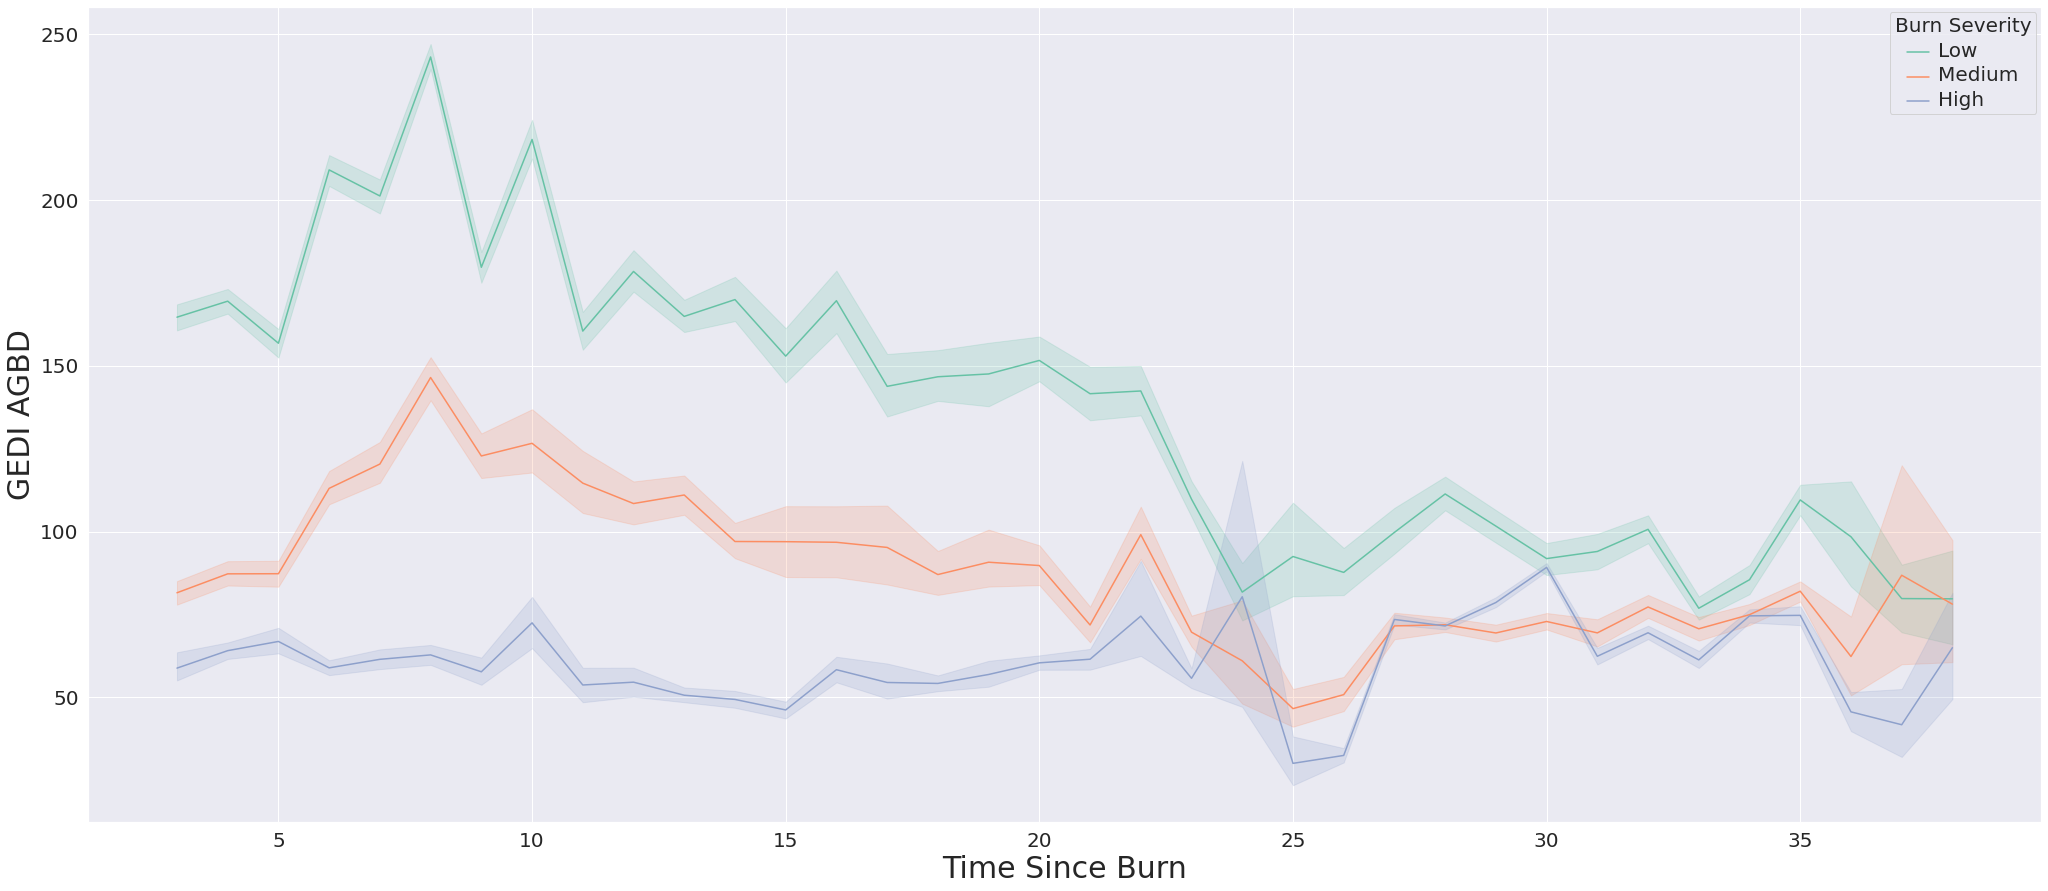

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(35, 15))
g = sns.lineplot(gedi_trees[gedi_trees.time_since_burn != -1], x='time_since_burn', y='agbd', hue='burn_severity_median', palette='Set2')
g.get_legend().set_title('Burn Severity')
new_labels = ['Low', 'Medium', 'High']
for t, l in zip(g.get_legend().texts, new_labels):
    t.set_text(l)

plt.setp(g.get_legend().get_texts(), fontsize='20') 
plt.setp(g.get_legend().get_title(), fontsize='20') 

#plt.legend(title='Burn Severity', loc='upper right', labels=['Low', 'Medium', 'High'])
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Time Since Burn', fontsize=30)
ax.set_ylabel('GEDI AGBD', fontsize=30)

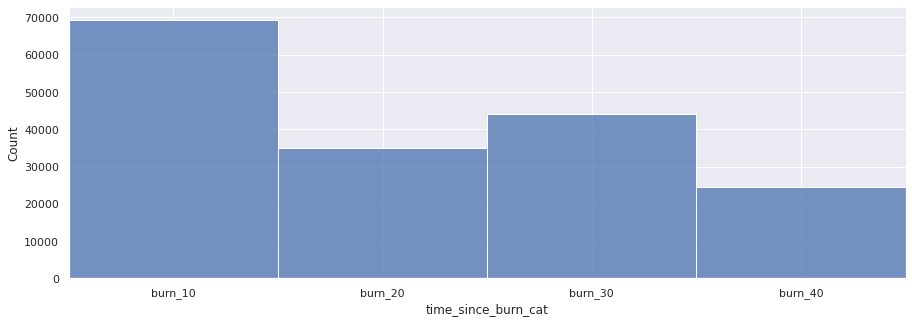

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
g = sns.histplot(gedi_trees[gedi_trees.time_since_burn != -1], x='time_since_burn_cat')
ax.margins(x=0)

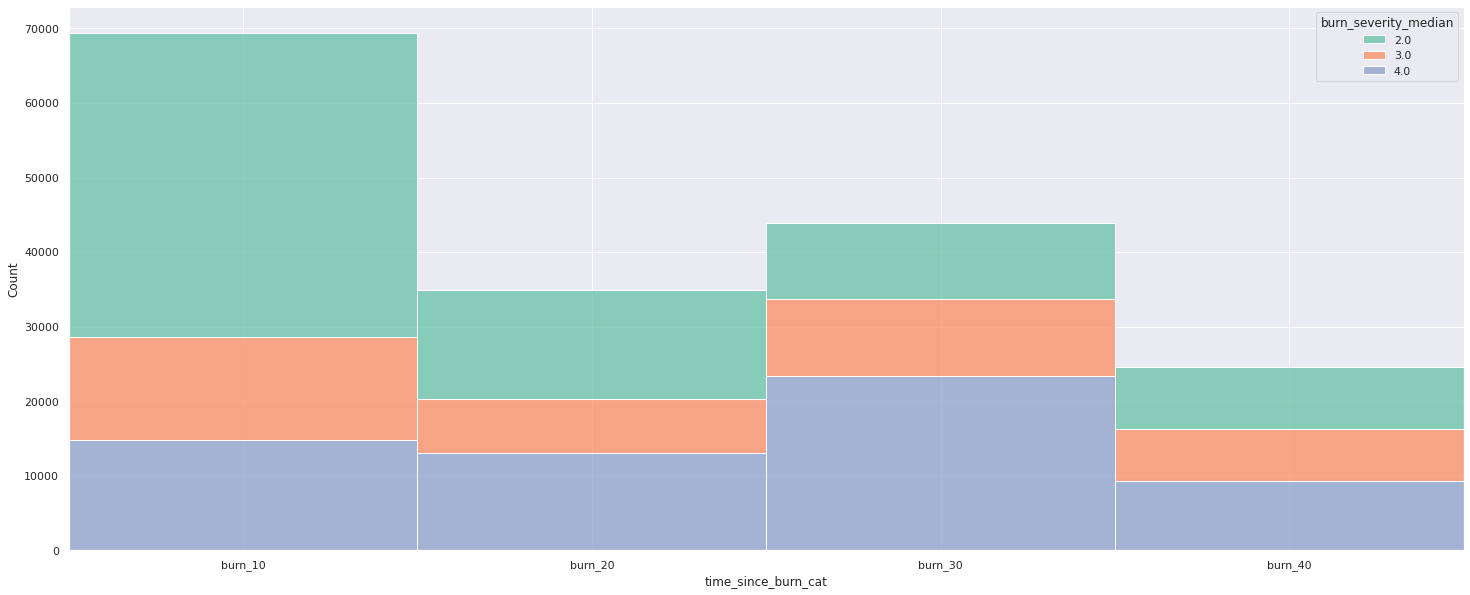

In [115]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.histplot(gedi_trees[gedi_trees.time_since_burn != -1], x='time_since_burn_cat', hue='burn_severity_median', palette='Set2', multiple="stack")
ax.margins(x=0)

In [116]:
gedi_burned_trees[gedi_burned_trees.burn_severity_median == 2].shape[0]

108723

Hypothesis to explain above: pixels that burned with low and medium severity > 30 years ago are more likely to reburn, than the ones that burned with high severity due to fuel reduction.

What percentage of each severity category reburns? Fire return interval must depend on the severity of the previous burn?

In [117]:
def plot_pdf(df: pd.DataFrame, x_col: str, y_col:str, x_label: str, y_label: str, y_lim: tuple):
    n = len(df)
    print(n)

    x = df[x_col].values
    y = df[y_col].values

    # Calculate the point density distribution per age group
    x_values = np.unique(x)
    z = np.zeros(y.shape)
    for i in x_values:
        z[x == i] = gaussian_kde(y[x == i])(y[x == i])


    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # limit to only the points with high enough density
    # x = x[z > 0.005]
    # y = y[z > 0.005]
    # z = z[z > 0.005]

    fig, ax = plt.subplots(1, 1, figsize=(25, 10))
    im = ax.scatter(x, y, c=z, s=500, cmap='PuRd')
    ax.set_ylim(y_lim)
    ax.set_xticks(x_values[::2])
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel(x_label, size=15)
    ax.set_ylabel(y_label, size=15)
    plt.colorbar(im)

    plt.show()

108723


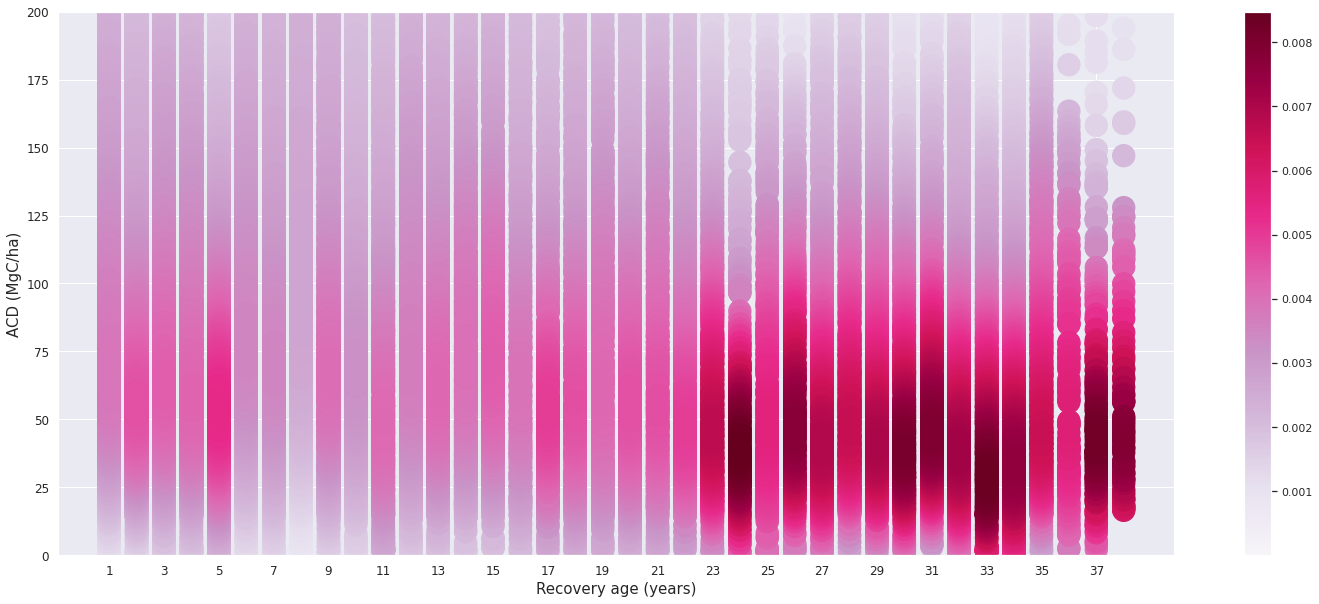

In [118]:
plot_pdf(gedi_burned_trees[gedi_burned_trees.burn_severity_median == 2],
         'time_since_burn',
         'agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 200))

57017


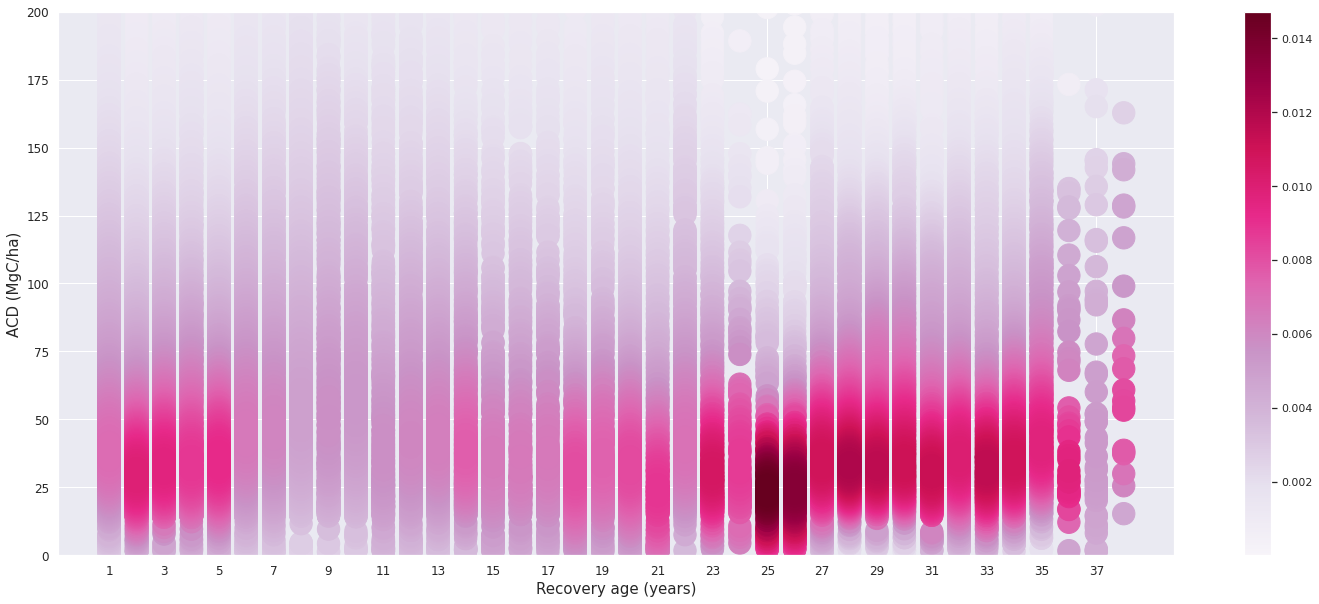

In [119]:
plot_pdf(gedi_burned_trees[gedi_burned_trees.burn_severity_median == 3],
         'time_since_burn',
         'agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 200))

94900


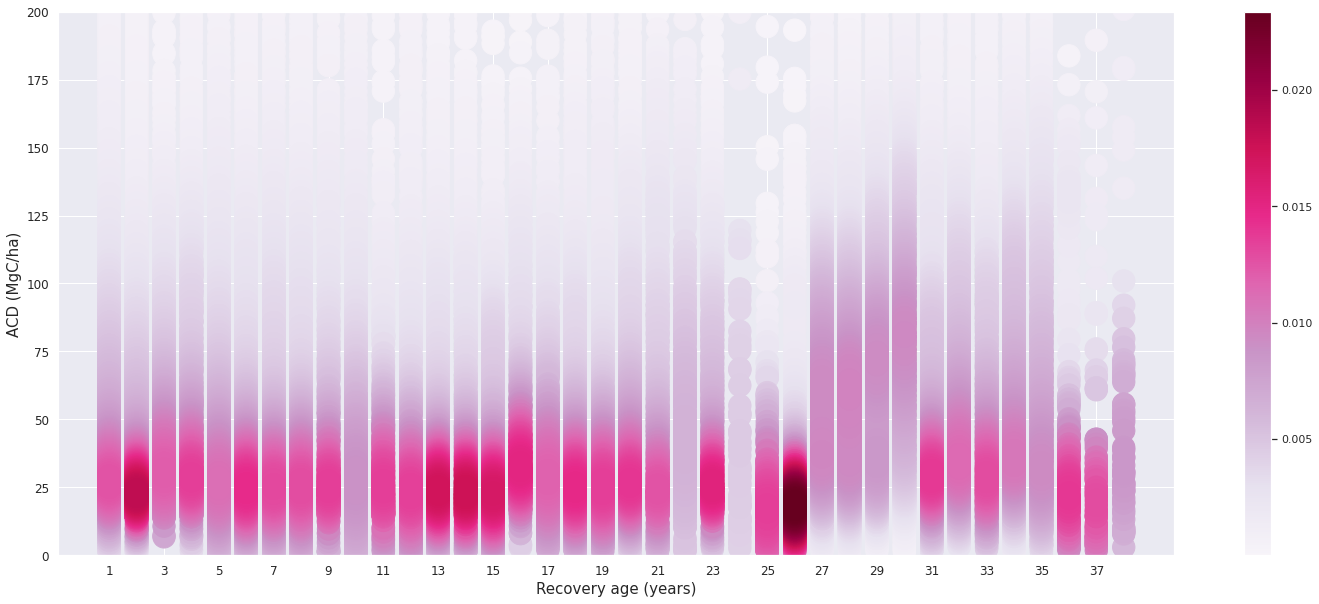

In [120]:
plot_pdf(gedi_burned_trees[gedi_burned_trees.burn_severity_median == 4],
         'time_since_burn',
         'agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 200))

### Plot the data geographically

In [31]:
sierras = gpd.read_file("../../data/shapefiles/sierras_convex_hull.shp")

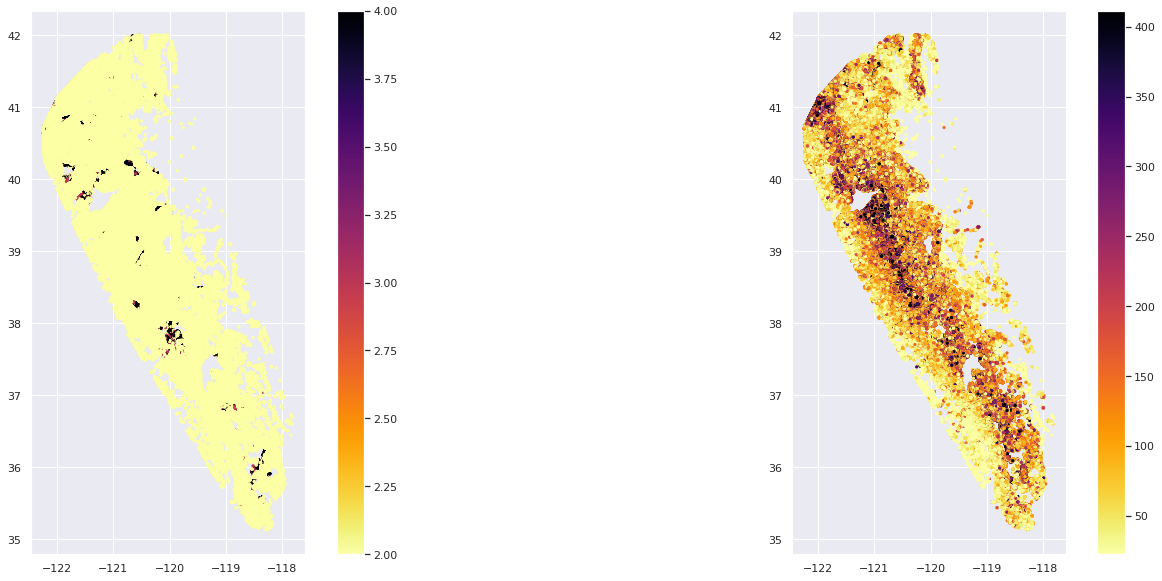

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(25,10))
geo_plot(gedi_trees, ax[0], 'burn_severity_median', vmin=2, vmax=4)
geo_plot(gedi_trees, ax[1], 'agbd')

<AxesSubplot: >

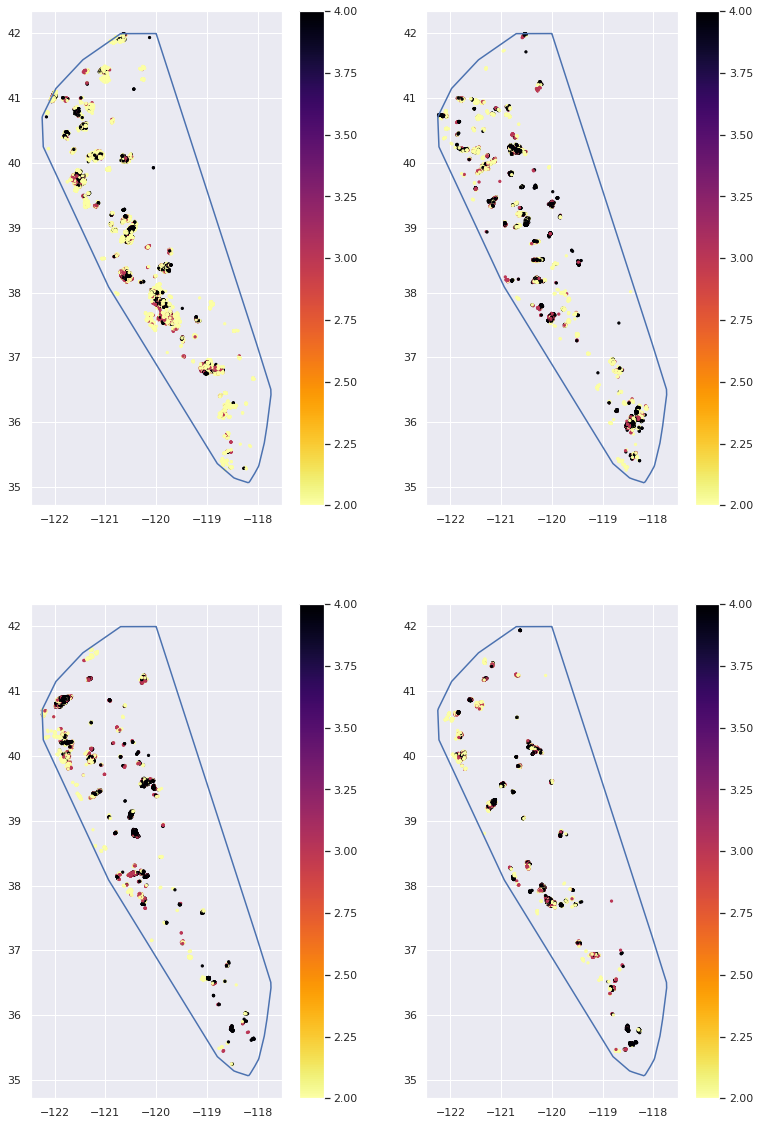

In [204]:
fig, ax = plt.subplots(2, 2, figsize=(13, 20))
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_10'], ax[0][0], 'burn_severity_median', vmin=2, vmax=4)
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_20'], ax[0][1], 'burn_severity_median', vmin=2, vmax=4)
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_30'], ax[1][0], 'burn_severity_median', vmin=2, vmax=4)
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_40'], ax[1][1], 'burn_severity_median', vmin=2, vmax=4)
sierras.boundary.plot(ax=ax[0][0])
sierras.boundary.plot(ax=ax[0][1])
sierras.boundary.plot(ax=ax[1][0])
sierras.boundary.plot(ax=ax[1][1])

<AxesSubplot: >

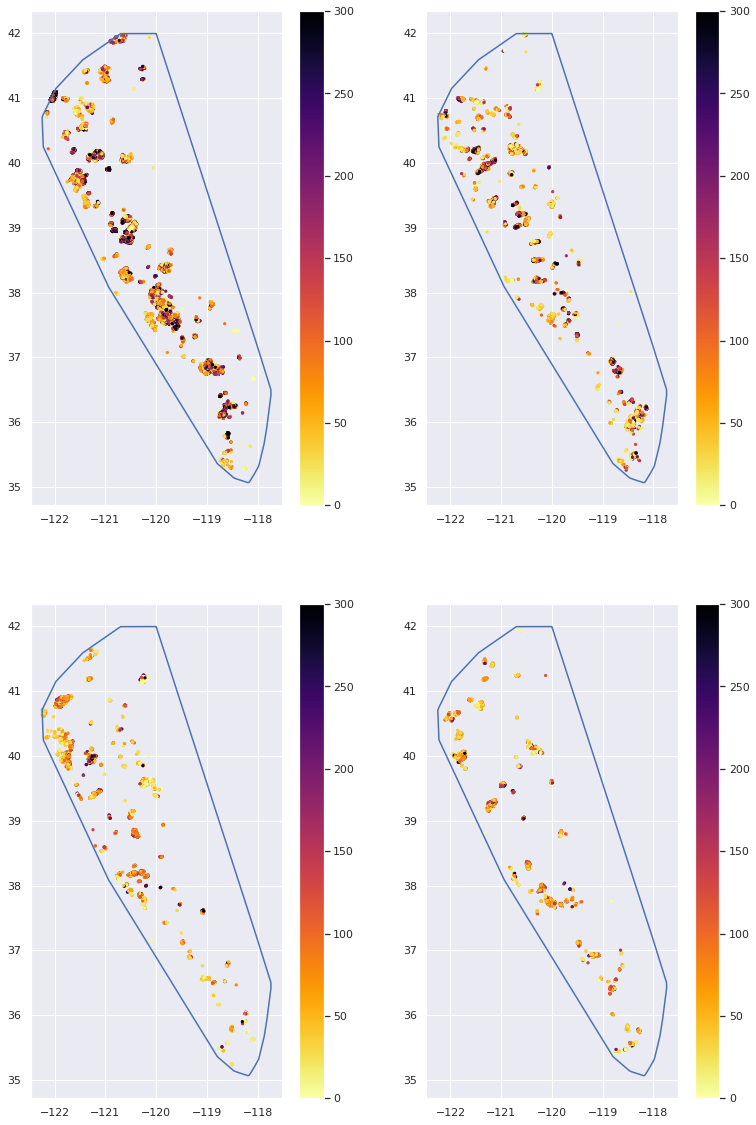

In [222]:
fig, ax = plt.subplots(2, 2, figsize=(13, 20))
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_10'], ax[0][0], 'agbd', vmin=0, vmax=300)
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_20'], ax[0][1], 'agbd', vmin=0, vmax=300)
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_30'], ax[1][0], 'agbd', vmin=0, vmax=300)
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'burn_40'], ax[1][1], 'agbd', vmin=0, vmax=300)
sierras.boundary.plot(ax=ax[0][0])
sierras.boundary.plot(ax=ax[0][1])
sierras.boundary.plot(ax=ax[1][0])
sierras.boundary.plot(ax=ax[1][1])

<AxesSubplot: >

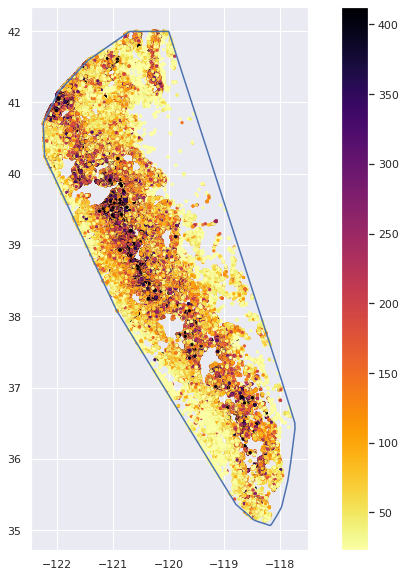

In [225]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
geo_plot(gedi_trees[gedi_trees.time_since_burn_cat == 'unburned'], ax, 'agbd')
sierras.boundary.plot(ax=ax)

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<AxesSubplot: >

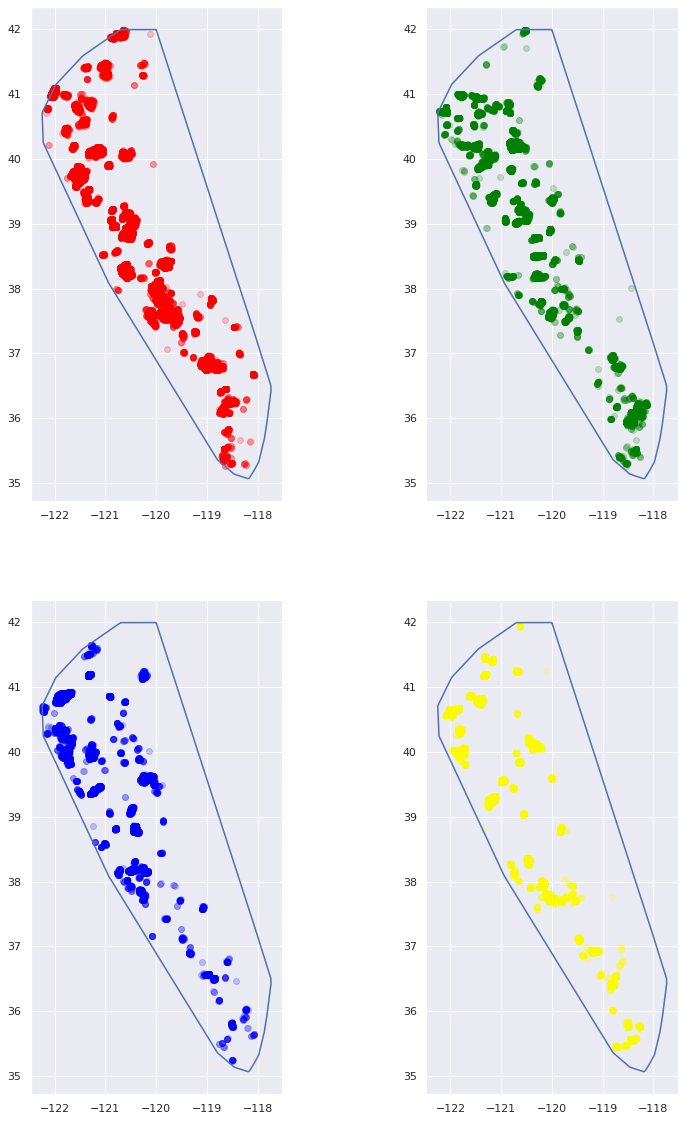

In [210]:
fig, ax = plt.subplots(2, 2, figsize=(13, 20))
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_10'].plot(column='agbd', ax=ax[0][0], legend=True, color='red', alpha=0.2)
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_20'].plot(column='agbd', ax=ax[0][1], legend=True, color='green', alpha=0.2)
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_30'].plot(column='agbd', ax=ax[1][0], legend=True, color='blue', alpha=0.2)
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_40'].plot(column='agbd', ax=ax[1][1], legend=True, color='yellow', alpha=0.2)
sierras.boundary.plot(ax=ax[0][0])
sierras.boundary.plot(ax=ax[0][1])
sierras.boundary.plot(ax=ax[1][0])
sierras.boundary.plot(ax=ax[1][1])

/home/jk871/drought-with-gedi/drought/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


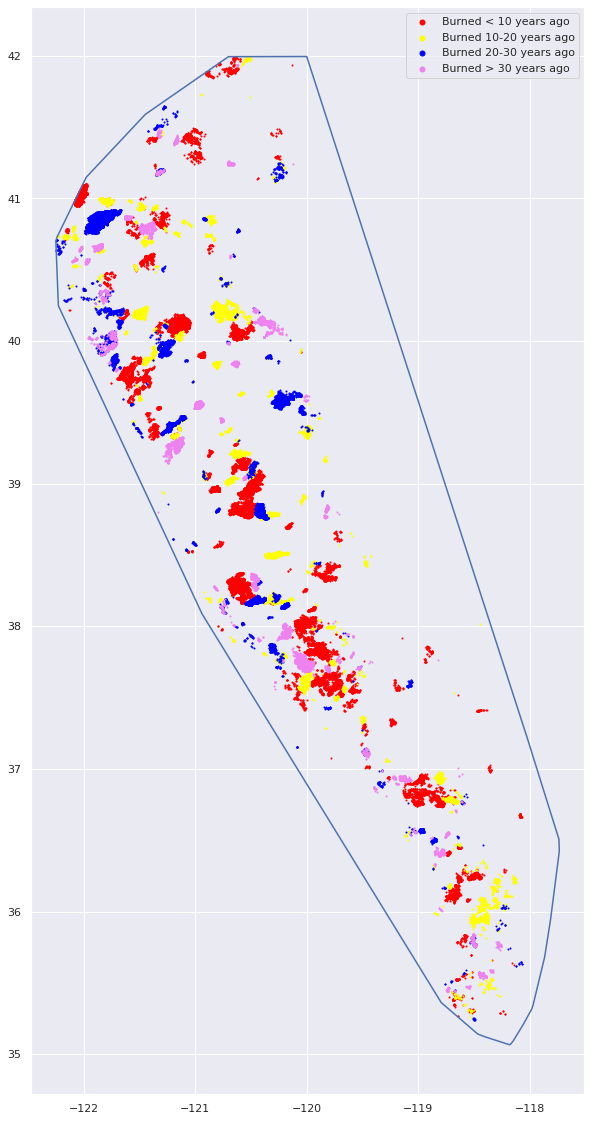

In [219]:
fig, ax = plt.subplots(1,1, figsize=(13, 20))
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_10'].plot(column='agbd', ax=ax, legend=True, color='red', markersize=1)
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_20'].plot(column='agbd', ax=ax, legend=True, color='yellow', markersize=1)
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_30'].plot(column='agbd', ax=ax, legend=True, color='blue', markersize=1)
gedi_trees[gedi_trees.time_since_burn_cat == 'burn_40'].plot(column='agbd', ax=ax, legend=True, color='violet', markersize=1)

sierras.boundary.plot(ax=ax)
plt.legend(['Burned < 10 years ago', 'Burned 10-20 years ago', 'Burned 20-30 years ago', 'Burned > 30 years ago'], markerscale = 5)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(35, 10))
sns.pointplot(gedi_burned_trees[gedi_burned_trees.burn_severity_sample == 2], x='time_since_burn', y='agbd')
sns.pointplot(gedi_burn_imperfect_match[gedi_burn_imperfect_match.burn_severity_sample == 1], x='time_since_burn', y='agbd', color='red')

### Look at unburned region

In [73]:
print(f'GEDI unburned shots: {gedi_unburned.shape[0]}')
print(f'GEDI unburned tree shots: {gedi_unburned_trees.shape[0]}')

GEDI unburned shots: 7829875


In [78]:
print('AGBD stats for unburned')
print(gedi_unburned_trees.agbd.describe())

print('AGBD stats for burned')
print(gedi_burned_trees.agbd.describe())

AGBD stats for unburned
count    2.856458e+06
mean     1.531952e+02
std      1.317868e+02
min      4.797173e-01
25%      5.792078e+01
50%      1.157059e+02
75%      2.078579e+02
max      4.822505e+03
Name: agbd, dtype: float64
AGBD stats for burned
count    126224.000000
mean        110.389136
std         122.778903
min           0.834731
25%          32.127316
50%          69.451138
75%         136.369278
max        2114.207764
Name: agbd, dtype: float64


In [79]:
print('AGBD stats for burned, severity == 2')
print(gedi_burned_trees[gedi_burned_trees.burn_severity_median==2].agbd.describe())

print('AGBD stats for burned, severity == 3')
print(gedi_burned_trees[gedi_burned_trees.burn_severity_median==3].agbd.describe())

print('AGBD stats for burned, severity == 4')
print(gedi_burned_trees[gedi_burned_trees.burn_severity_median==4].agbd.describe())

AGBD stats for burned, severity == 2
count    44429.000000
mean       185.359152
std        159.512139
min          0.870713
25%         66.874855
50%        140.779327
75%        256.842957
max       1914.888306
Name: agbd, dtype: float64
AGBD stats for burned, severity == 3
count    17193.000000
mean        87.445992
std         93.397168
min          1.009095
25%         30.505957
50%         58.366970
75%        110.912811
max       2086.356445
Name: agbd, dtype: float64
AGBD stats for burned, severity == 4
count    64602.000000
mean        64.935723
std         59.686386
min          0.834731
25%         24.993123
50%         48.109180
75%         87.826307
max       2114.207764
Name: agbd, dtype: float64


(0.0, 1500.0)

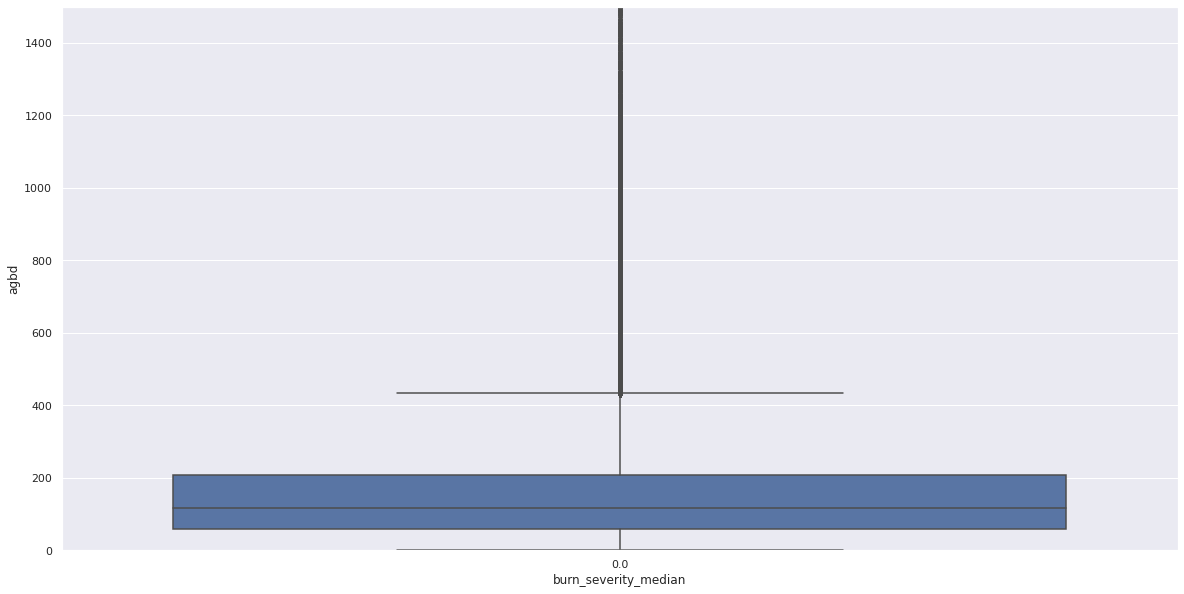

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
sns.boxplot(gedi_unburned_trees, x='burn_severity_median', y='agbd')
ax.set_ylim((0, 1500))